In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install tensorflow

In [3]:
#!python -m pip install tensorflow-gpu==2.8.3

In [4]:
path="/content/drive/MyDrive/PlantVillage"

In [5]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [6]:
image_size=256
batch_size=32
channels=3

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    path,
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size)

Found 2152 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

In [10]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 1 0 0 1 0 0 0 1 1 1 1 0 1 2 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1]


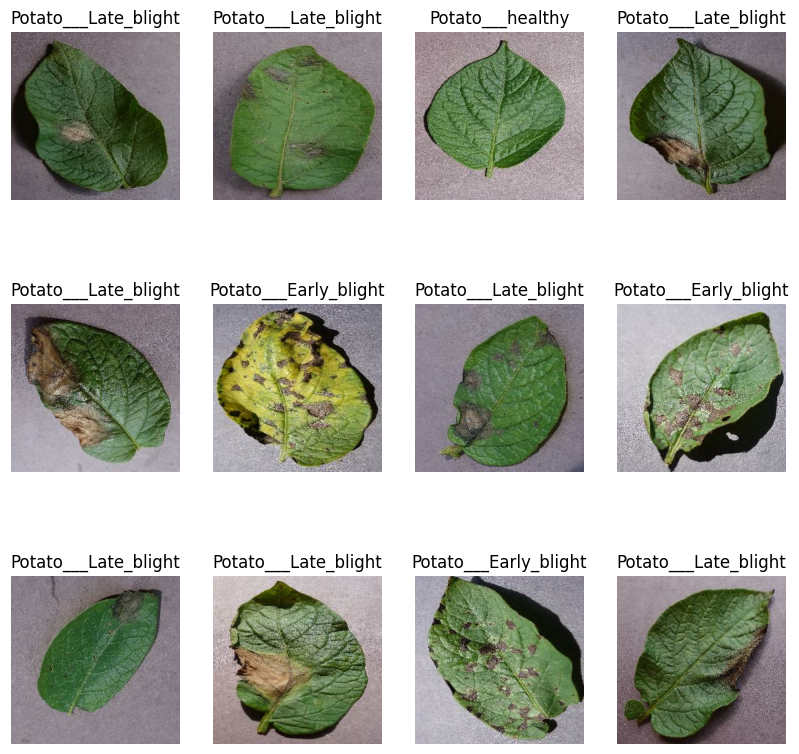

In [11]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
     ax=plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])
     plt.axis("off")

### 80% ==> training
### 20% ==> 10% validation,10%test

In [12]:
train_size=0.8
len(dataset)*train_size


54.400000000000006

In [13]:
train_ds=dataset.take(54)
len(train_ds)

54

In [14]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [15]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [16]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [17]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [18]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)

  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)
  return train_ds,val_ds,test_ds


In [19]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [23]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),])

In [26]:
n_classes=3
input_shape=(batch_size,image_size,image_size,channels)
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax"),
])
model.build(input_shape=input_shape)


In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [28]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [29]:
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,

)

In [39]:
EPOCHS=50
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds)

Epoch 1/50
54/54 [==============================] - 3s 62ms/step - loss: 0.2482 - accuracy: 0.9091 - val_loss: 0.1636 - val_accuracy: 0.9375
Epoch 2/50
54/54 [==============================] - 3s 63ms/step - loss: 0.1390 - accuracy: 0.9508 - val_loss: 0.2774 - val_accuracy: 0.8854
Epoch 3/50
54/54 [==============================] - 4s 65ms/step - loss: 0.1264 - accuracy: 0.9514 - val_loss: 0.3765 - val_accuracy: 0.8542
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.1119 - accuracy: 0.9566 - val_loss: 0.1022 - val_accuracy: 0.9583
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.1085 - accuracy: 0.9606 - val_loss: 0.0848 - val_accuracy: 0.9740
Epoch 6/50
54/54 [==============================] - 3s 61ms/step - loss: 0.0771 - accuracy: 0.9722 - val_loss: 0.0445 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 3s 62ms/step - loss: 0.1672 - accuracy: 0.9363 - val_loss: 0.0933 - val_accuracy: 0.9688
Epoch 8/50
54

In [40]:
scores=model.evaluate(test_ds)
scores

8/8 [==============================] - 0s 29ms/step - loss: 0.2123 - accuracy: 0.9414


[0.21232689917087555, 0.94140625]

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
history.history["accuracy"]

[0.9091435074806213,
 0.9508101940155029,
 0.9513888955116272,
 0.9565972089767456,
 0.9606481194496155,
 0.9722222089767456,
 0.9363425970077515,
 0.9646990895271301,
 0.9733796119689941,
 0.96875,
 0.9675925970077515,
 0.9745370149612427,
 0.9751157164573669,
 0.9664351940155029,
 0.9728009104728699,
 0.9832175970077515,
 0.9762731194496155,
 0.9797453880310059,
 0.9872685074806213,
 0.9878472089767456,
 0.9884259104728699,
 0.9837962985038757,
 0.9849537014961243,
 0.9901620149612427,
 0.9895833134651184,
 0.984375,
 0.9884259104728699,
 0.9890046119689941,
 0.9670138955116272,
 0.9861111044883728,
 0.9890046119689941,
 0.9913194179534912,
 0.9907407164573669,
 0.9953703880310059,
 0.9878472089767456,
 0.9820601940155029,
 0.9884259104728699,
 0.9907407164573669,
 0.9913194179534912,
 0.9884259104728699,
 0.9866898059844971,
 0.9913194179534912,
 0.9942129850387573,
 0.9971064925193787,
 0.9930555820465088,
 0.9884259104728699,
 0.9982638955116272,
 0.9791666865348816,
 0.9901620149

In [46]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

Text(0.5, 1.0, 'Traing and Validation Accuracy')

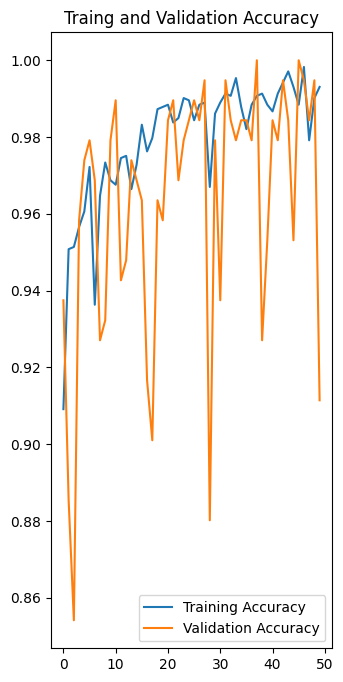

In [47]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Traing and Validation Accuracy")

# plt.subplot(1,2,2)
# plt.plot(range(EPOCHS),loss,label="Training Loss")
# plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
# plt.legend(loc="best")
# plt.title("Traing and Validation Loss")
# plt.show()


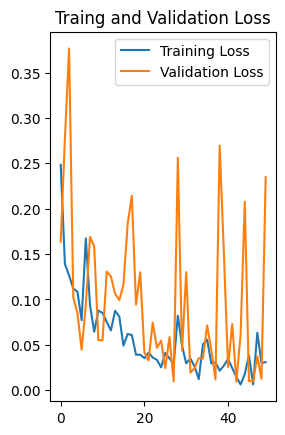

In [48]:
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc="best")
plt.title("Traing and Validation Loss")
plt.show()

First image to predict
Actual label : Potato___Late_blight
1/1 [==============================] - 0s 63ms/step
predicted label : Potato___Late_blight


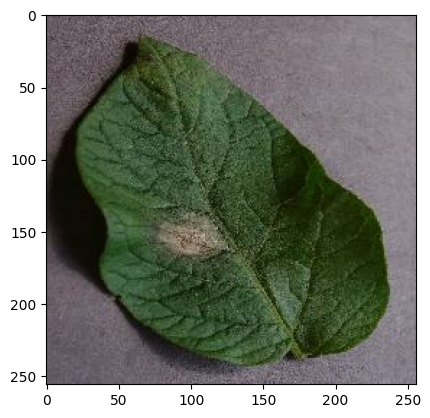

In [50]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
  first_image=image_batch[0].numpy().astype("uint8")
  first_label=labels_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("Actual label :",class_names[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label :",class_names[np.argmax(batch_prediction[0])])

In [73]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Use the provided image 'img'
    img_array = tf.expand_dims(img_array, axis=0)  # Add batch dimension
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 19ms/step


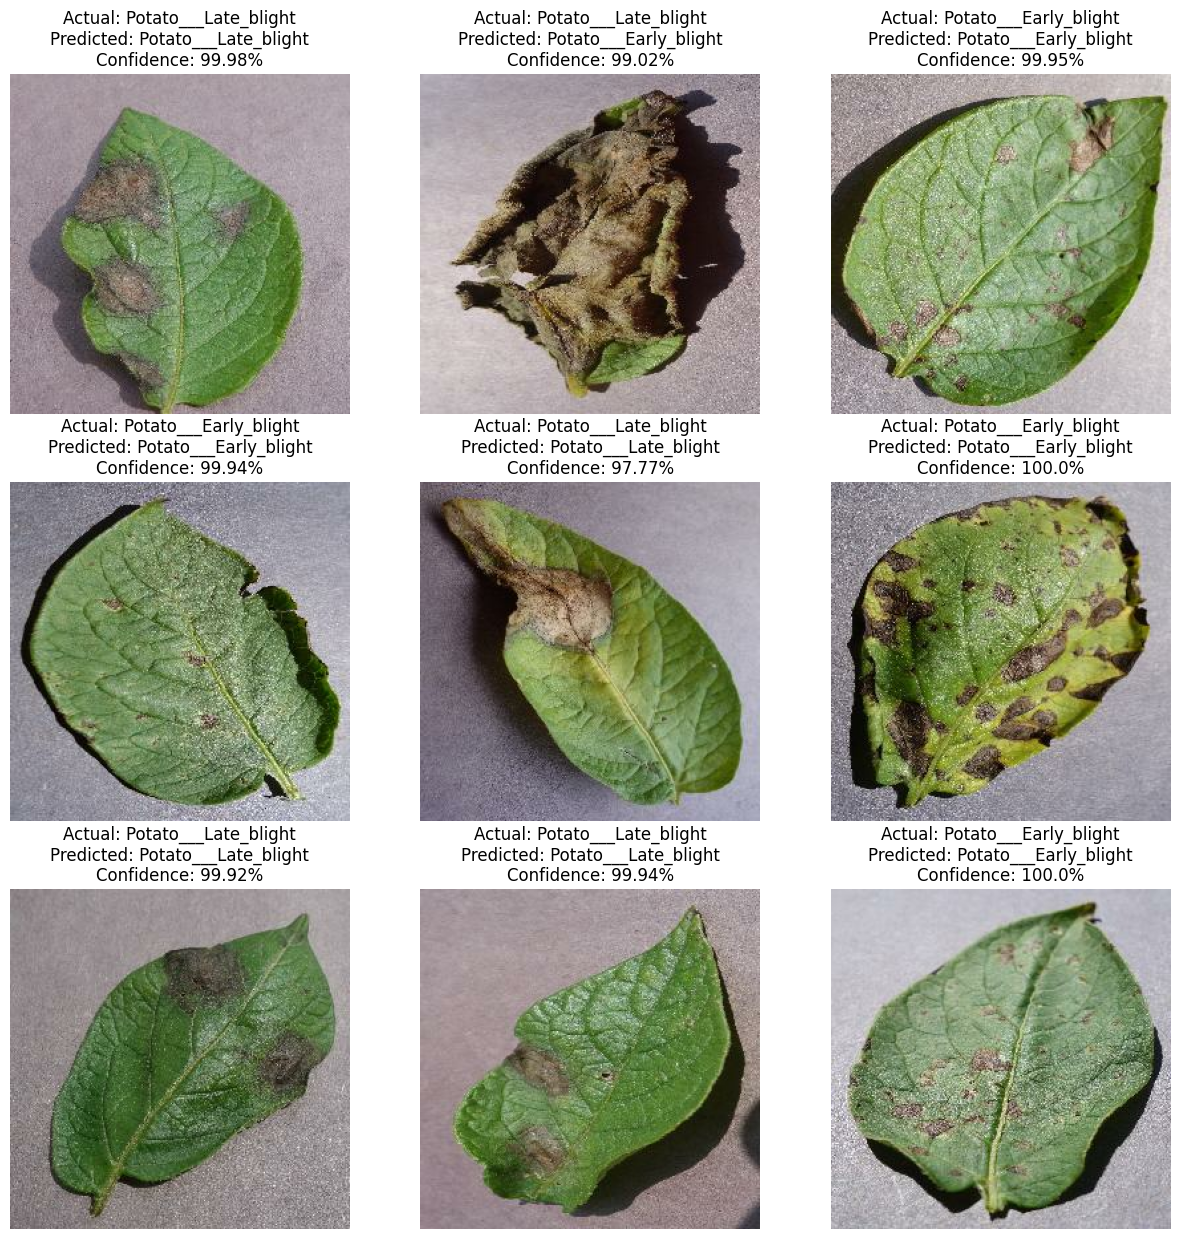

In [74]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i])  # Pass 'images[i]' directly
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")

plt.show()


In [75]:

model.save('/content/drive/MyDrive/model2.h5')